In [22]:
!pip install yfinance

In [135]:
import yfinance as yf
import urllib
from bs4 import BeautifulSoup
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import requests
import os.path
from os import path

In [136]:
pd.options.mode.chained_assignment = None

In [77]:
symbol = 'aapl'
term = 3
gain = 0.15

In [133]:
def loadData(symbol, term, gain):
  stock = yf.Ticker(symbol)
  # Get Stock price history
  history = stock.history(period="2y")
  history = history.reset_index()
  # Get Stock financiales
  url = 'https://www.marketwatch.com/investing/stock/' + symbol + '/financials/income/quarter'
  text_soup = BeautifulSoup(urllib.request.urlopen(url).read())
  dates = []
  eps = []
  titles = text_soup.findAll('td', {'class': 'rowTitle'})
  for title in titles:
      if 'EPS (Basic)' in title.text:
        eps = [td.text for td in title.findNextSiblings(attrs={'class': 'valueCell'}) if td.text]
        break
  titles2 = text_soup.findAll('th', {'class': 'rowTitle'})
  for title in titles2:
      if 'All values' in title.text:
        dates = [td.text for td in title.findNextSiblings() if td.text]
  dates = dates[:len(dates) - 1]
  # Fill financials
  data = { 'date': dates, 'eps': eps }
  financials = pd.DataFrame(data)
  financials['date'] = pd.to_datetime(financials['date'])
  financials['eps'] = pd.to_numeric(financials['eps'])
  # Calculate fields
  last = history.iloc[-1]
  year = pd.Timedelta(365, 'days')
  months_1 = pd.Timedelta(30, 'days')
  months_3 = pd.Timedelta(91, 'days')
  months_6 = pd.Timedelta(182, 'days')
  days_5 = pd.Timedelta(5, 'days')
  days_50 = pd.Timedelta(50, 'days')
  days_200 = pd.Timedelta(200, 'days')
  days_300 = pd.Timedelta(300, 'days')
  last['eps'] = financials.iloc[-1]['eps']
  last['pe'] = last['Close'] / last['eps']
  price_1 = history.loc[(history['Date'] >= (last['Date'] - months_1)) & (history['Date'] >= (last['Date'] - months_1 + days_5))].iloc[0]['Close']
  price_3 = history.loc[(history['Date'] >= (last['Date'] - months_3)) & (history['Date'] >= (last['Date'] - months_3 + days_5))].iloc[0]['Close']
  price_6 = history.loc[(history['Date'] >= (last['Date'] - months_6)) & (history['Date'] >= (last['Date'] - months_6 + days_5))].iloc[0]['Close']
  price_12 = history.loc[(history['Date'] >= (last['Date'] - year)) & (history['Date'] >= (last['Date'] - year + days_5))].iloc[0]['Close']
  yield_1 = last['Close'] / price_1 * 100
  yield_3 = last['Close'] / price_3 * 100
  yield_6 = last['Close'] / price_6 * 100
  yield_12 = last['Close'] / price_12 * 100
  last['yield1'] = yield_1 - 100
  last['yield3'] = yield_3 - 100
  last['yield6'] =  yield_6 - 100
  last['yield12'] = yield_12 - 100
  last_50 = history.loc[(history['Date'] >= (last['Date'] - days_50)) & (history['Date'] <= last['Date'])]['Close'].mean()
  last_200 = history.loc[(history['Date'] >= (last['Date'] - days_200)) & (history['Date'] <= last['Date'])]['Close'].mean()
  last_300 = history.loc[(history['Date'] >= (last['Date'] - days_300)) & (history['Date'] <= last['Date'])]['Close'].mean()
  last['ma50'] = last_50 / last['Close']
  last['ma200'] = last_200 / last['Close']
  last['ma300'] =  last_300 / last['Close']
  last['term'] = term
  last['gain'] = gain
  # Shape to final form
  pr = last.drop('Date')
  pr = pr.drop('Open')
  pr = pr.drop('Close')
  pr = pr.drop('High')
  pr = pr.drop('Low')
  pr = pr.drop('Volume')
  pr = pr.drop('Dividends')
  pr = pr.drop('Stock Splits')
  return pr

In [114]:
def loadModel():
  if not path.exists('model.h5'):
    url = 'https://raw.githubusercontent.com/alexhg128/StocksClassifier/master/CompiledModels/stocks.h5'
    r = requests.get(url, allow_redirects=True)
    open('model.h5', 'wb').write(r.content)
  return keras.models.load_model('model.h5')

In [107]:
def intTryParse(value):
    try:
        return int(value), True
    except ValueError:
        return value, False

def floatTryParse(value):
    try:
        return float(value), True
    except ValueError:
        return value, False

In [144]:
def plot_value_array(i, predictions_array):
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])

  thisplot[0].set_color('blue')
  thisplot[1].set_color('blue')

Enter stock symbol
GOOG

Enter desired term (3/6/12)
12

Enter desired term (0.05/0.10/0.15/0.20)
0.2

Recommendation: Sell

Buy  -> 0.027340708
Sell -> 0.97265935



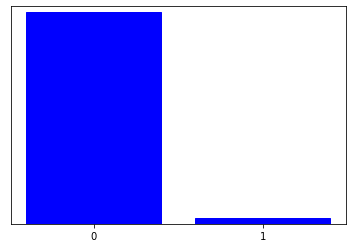

In [147]:
labels = ['Sell', 'Buy']

print('Enter stock symbol')
symbol = input()

print()
print('Enter desired term (3/6/12)')
term = input()

print()
print('Enter desired term (0.05/0.10/0.15/0.20)')
gain = input()

data = loadData(symbol.lower(), np.int64(term), np.float64(gain))
model = loadModel()
predictions = model.predict(np.asarray([data]).astype(np.float32))
print()
print('Recommendation: ' + labels[np.argmax(predictions[0])])
print()
print('Buy  -> ' + str(predictions[0][1]))
print('Sell -> ' + str(predictions[0][0]))
print()

plot_value_array(0, predictions[0])
plt.show()